<a href="https://colab.research.google.com/github/seismomat/IBEM/blob/Lili/IBEM_TOPOGRAFIA_GAUSSIANA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Se importan bibliotecas:
import math
import scipy.special as scis
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

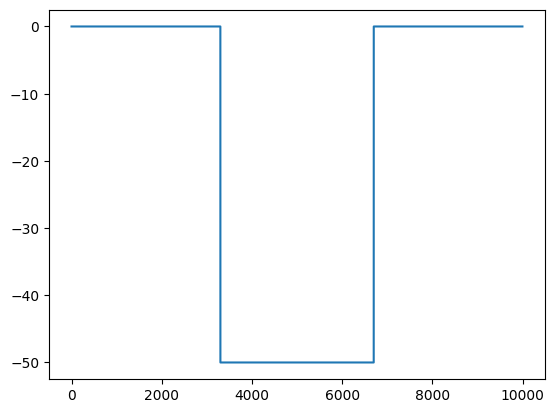

In [2]:
#Geometría del problema
LMax=10000 #m Longitud

L1=3300 #m
L2=3400 #m
L3=3300 #m

L=np.array([0,L1,L1+1,L1+L2,L1+L2+1,L1+L2+L3-3])

H1=0 #m
H2=-50 #m
H3=0 # #m

H=np.array([H1,H1,H2,H2,H3,H3])

plt.plot(L,H)
plt.show()

In [3]:
#Parḿetros del problema
#Periodo
T=2 #s
#Frecuencia fundamental
f0=1/T #1/s
#Diferencial de tiempo
dt=0.05 #s
#Número de frecuencias
N=64
#Frecuencia máxima
fmax=1/(2*dt)
#Diferencial de frecuencia
df=1/((N)*dt)

#Vector de frecuencias
f = np.arange(df, fmax, df)
#Vector de frecuencia angular
w = 2*np.pi*f

#Velocidad
beta=2500
#Densidad
rho=2500

#Vector de longitud de onda
lambd = beta/f
#Vector de número de onda
k = w / beta

#Puntos por longitud de onda
NP=16

#Vector distancia entre segmentos para cada lambda/NP
dx=lambd/NP

#Ubicación de la fuente
Fuente=np.array([5000,-100])


In [4]:
#FUNCION NUEVA PARA CONSTRUIR SEGMENTOS:
def segmentos(dx):
  ds=dx

  #segmento 1:
  ns1=int(L1/ds)
  #Se crea vector con coordenadas de los segmentos
  segmento1=np.zeros((int(ns1)+1,2))
  segmento1[:,0]=np.linspace(0,L1-1,int(ns1)+1)
  segmento1[:,1]=0

  #Se obtienen la distancia para definir puntos medios:
  dxp=segmento1[1,0]-segmento1[0,0]

  #Se crea vector con coordenadas de los puntos entre segmentos
  xp1=np.zeros((int(ns1),2))
  xp1[:,0]=segmento1[:-1,0]+dxp/2

  #segmento vertical:
  ns2=abs(int(min(H)/ds))
  #Se crea vector con coordenadas de los segmentos
  segmento2=np.zeros((int(ns2)+1,2))
  segmento2[:,0]=np.linspace(L1,L1+1,int(ns2)+1)
  segmento2[:,1]=np.linspace(0,H2,int(ns2)+1)

  #Se crea vector con coordenadas de los puntos entre segmentos
  xp2=np.zeros((int(ns2),2))
  xp2[:,0]=segmento2[:-1,0]+dxp/2
  xp2[:,1]=segmento2[:-1,1]-dxp/2

  #segmento 2:
  ns3=int(((L1+L2)-(L1+1))/ds)
  #Se crea vector con coordenadas de los segmentos
  segmento3=np.zeros((int(ns3)+1,2))
  segmento3[:,0]=np.linspace(L1+2,L1+L2,int(ns3)+1)
  segmento3[:,1]=-50

  #Se crea vector con coordenadas de los puntos entre segmentos
  xp3=np.zeros((int(ns3),2))
  xp3[:,0]=segmento3[:-1,0]+dxp/2
  xp3[:,1]=-50

  #segmento vertical:
  ns4=ns2
  #Se crea vector con coordenadas de los segmentos
  segmento4=np.zeros((int(ns4)+1,2))
  segmento4[:,0]=np.linspace(L1+L2+1,L1+L2+2,int(ns2)+1)
  segmento4[:,1]=np.linspace(H2,0,int(ns2)+1)

  #Se crea vector con coordenadas de los puntos entre segmentos
  xp4=np.zeros((int(ns4),2))
  xp4[:,0]=segmento4[:-1,0]+dxp/2
  xp4[:,1]=segmento4[:-1,1]+dxp/2

  #segmento final:
  ns5=int(((L1+L2+L3-3)-(L1+L2+1))/ds)
  #Se crea vector con coordenadas de los segmentos
  segmento5=np.zeros((int(ns5)+1,2))
  segmento5[:,0]=np.linspace(L1+L2+3,L1+L2+L3,int(ns5)+1)
  segmento5[:,1]=0

  #Se crea vector con coordenadas de los puntos entre segmentos
  xp5=np.zeros((int(ns5),2))
  xp5[:,0]=segmento5[:-1,0]+dxp/2
  xp5[:,1]=0

  #UNION DE SEGMENTOS:
  nsT=ns1+ns2+ns3+ns4+ns5+5
  segmento=np.zeros((int(nsT),2))
  xp=np.zeros((int(nsT-5),2))

  segmento[:,0]=np.concatenate((segmento1[:,0], segmento2[:,0], segmento3[:,0], segmento4[:,0], segmento5[:,0]))
  segmento[:,1]=np.concatenate((segmento1[:,1], segmento2[:,1], segmento3[:,1], segmento4[:,1], segmento5[:,1]))

  xp[:,0]=np.concatenate((xp1[:,0],xp2[:,0],xp3[:,0],xp4[:,0],xp5[:,0]))
  xp[:,1]=np.concatenate((xp1[:,1],xp2[:,1],xp3[:,1],xp4[:,1],xp5[:,1]))

  return segmento, xp, nsT

In [5]:
#FUNCIÓN DE VECTORES NORMALES:
def normales(segmento):
  #Variables de entrada:
  #   segmento: vector de coordenadas

  #Se obtienen vectores normales:
  AB=segmento[1:]-segmento[:-1] #Diferencia
  nor=AB[:,0] #Para obtener unitario
  normal=AB*0 #Auxiliar
  #Vector normal invirtiendo coordenadas y signo
  normal[:,0]=-AB[:,1]/nor
  normal[:,1]=AB[:,0]/nor
  #Regresa vectores normales de los segmentos
  return normal

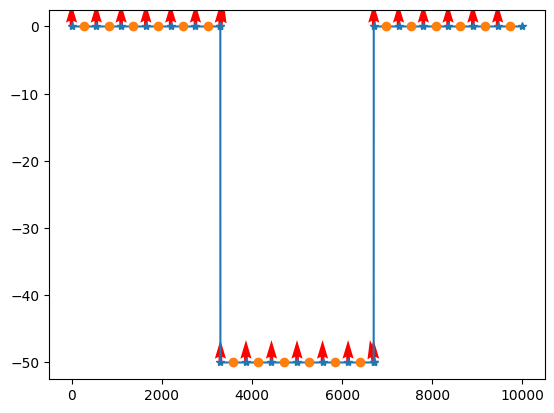

In [6]:
#PRUEBA DE QUE FUNCIONAN CREACION DE SEGMENTOS
segmento, xp, ns=segmentos(dx[0])
normal=normales(segmento)
#print((normal))
plt.plot(segmento[:,0],segmento[:,1],marker = '*')
plt.plot(xp[:,0],xp[:,1],'o')
plt.quiver(segmento[:-1, 0], segmento[:-1, 1],
          normal[:, 0], normal[:, 1],
          angles='xy', scale_units='xy', scale=0.3, color='r', label='Vectores Normales')
plt.show()

In [7]:
#Función T22:
def T22(k,x,xi,normal):
  # Variables de entrada:
  # k: número de onda
  # x: Punto sobre el que se calculan las contribuciones de los otros segmentos (vector)
  # xi: Punto correspondiente al otro segmento (vector)
  # normal: vector normal
    #Se obtiene norma
    r= la.norm(x-xi)
    #Se calcula función de hankel
    D = k*r * scis.hankel2(1,k*r)
    #Producto punto entre vector normal y gamma
    g_n=(x[0]-xi[0])/r * normal[0] + (x[1]-xi[1])/r * normal[1]
    #Regresa la función T22
    return 1j/(4*r) * D * g_n

#Función G22:
def G22(k,x,xi,beta,rho):
    r=la.norm(x-xi)
    H=scis.hankel2(0,k*r)
    return (1/(1j*4*rho)) * (H/(beta**2))

#Integración Gaussiana de T22
def Int_T22(n,l,k,segmento,xp,normal):
  #Variables de entrada:
  # n: índice de x
  # l: índice de xi
  # segmento: Vector de segmentos
  # xp: vector de puntos medios entre segmentos
  # normal: vector normal

    #Para 5 puntos:
    nodos = [-0.906179845938664, -0.538469310105683,0, 0.538469310105683, 0.906179845938664]
    pesos = [0.236926885056189, 0.478628670499366, 0.568888888888889, 0.478628670499366, 0.236926885056189]

    #Para x (Horizontal)
    #Se definen límites según el segmento (definido por l)
    b=segmento[l,0]
    a=segmento[l+1,0]
    xix_nodo = []  # Crear una lista vacía para almacenar los resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xix_nodo.append(resultado) #Mete resultado a la lista

    #Para z (Vertical)
    #Se definen límites según el segmento (definido por l)
    b=segmento[l,1]
    a=segmento[l+1,1]
    xiz_nodo = [] #Lista vacía para almacenar resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xiz_nodo.append(resultado) #Mete resultado a la lista

    Xi_nodo = []  # Crear una lista vacía para almacenar las listas
    for i in range(len(nodos)):
      sublista = [xix_nodo[i], xiz_nodo[i]]  # Crea la sublista con nodos en x y z
      Xi_nodo.append(sublista)  # Agrega la sublista a la lista

    Xi_nodo = np.array(Xi_nodo) #Convierte lista a arreglo np, porque no funcionaba xD

    #Calcula distancia entre segmentos
    L=la.norm(segmento[l]-segmento[n])
    Int=0.0 #Variabke auxuliar para almacenar resultado de integral
    for i in range(len(nodos)):
        #Se calcula integral llamando a función T22 con los nodos
        Int += L/2 * pesos[i]*T22(k,xp[n],Xi_nodo[i],normal[n])
    #Regresa integral
    return Int

    #Integración Gaussiana de G22
def Int_G22(n,l,k,segmento,xp,normal):
  #Variables de entrada:
  # n: índice de x
  # l: índice de xi
  # segmento: Vector de segmentos
  # xp: vector de puntos medios entre segmentos
  # normal: vector normal

    #Para 5 puntos:
    nodos = [-0.906179845938664, -0.538469310105683,0, 0.538469310105683, 0.906179845938664]
    pesos = [0.236926885056189, 0.478628670499366, 0.568888888888889, 0.478628670499366, 0.236926885056189]

    #Para x (Horizontal)
    #Se definen límites según el segmento (definido por l)
    b=segmento[l,0]
    a=segmento[l+1,0]
    xix_nodo = []  # Crear una lista vacía para almacenar los resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xix_nodo.append(resultado) #Mete resultado a la lista

    #Para z (Vertical)
    #Se definen límites según el segmento (definido por l)
    b=segmento[l,1]
    a=segmento[l+1,1]
    xiz_nodo = [] #Lista vacía para almacenar resultados
    for nodo in nodos:
      resultado = (b - a) / 2 * nodo + (a + b) / 2  # Calcula el resultado para cada valor
      xiz_nodo.append(resultado) #Mete resultado a la lista

    Xi_nodo = []  # Crear una lista vacía para almacenar las listas
    for i in range(len(nodos)):
      sublista = [xix_nodo[i], xiz_nodo[i]]  # Crea la sublista con nodos en x y z
      Xi_nodo.append(sublista)  # Agrega la sublista a la lista

    Xi_nodo = np.array(Xi_nodo) #Convierte lista a arreglo np, porque no funcionaba xD

    #Calcula distancia entre segmentos

    L=la.norm(segmento[l]-xp[n])
    Int=0.0 #Variabke auxuliar para almacenar resultado de integral
    for i in range(len(nodos)):
        #Se calcula integral llamando a función T22 con los nodos
        Int += L/2 * pesos[i]*G22(k,xp[n],Xi_nodo[i],beta,rho)
    #Regresa integral
    return Int

In [9]:
#Construcción de matriz de tracciones para cada frecuencia:
MGeneral=[] #Variable auxiliar vacía

for i in range(len(f)): #Repite el procedimiento para cada frecuencia
  #Obtiene distribución de segmentos para cada longitud de onda (dx)
  segmento, xp, ns=segmentos(dx[i])
  #Obtiene vector normal para los segmentos obtenidos
  normal=normales(segmento)
  #Construye matriz para cada frecuencia
  M22=np.zeros([int(ns),int(ns)])
  #Le pone su parte imaginaria
  M22 = M22 + 0j*M22
  #Se construye matriz
  for n in range(int(ns)):
      for l in range(int(ns)):
          if n==l:
              M22[n,l]=0.5+0j
          else:
              M22[n,l]=Int_T22(n,l,k[i],segmento,xp,normal)
  #Se mete a la matriz obtenida para una frecuencia en la variable auxiliar
  MGeneral.append(M22)
  print('Frecuencia %d : %f'%(i+1,f[i]))
#print(M22)

IndexError: index 23 is out of bounds for axis 0 with size 23

In [ ]:

ds=dx[0]

#segmento 1:
ns1=int(L1/ds)
#Se crea vector con coordenadas de los segmentos
segmento1=np.zeros((int(ns1)+1,2))
segmento1[:,0]=np.linspace(0,L1-1,int(ns1)+1)
segmento1[:,1]=0

dxp1=segmento1[1,0]-segmento1[0,0]

#Se crea vector con coordenadas de los puntos entre segmentos
xp1=np.zeros((int(ns1),2))
xp1[:,0]=segmento1[:-1,0]+dxp/2
#print(len(xp))

#segmento vertical:
ns2=abs(int(min(H)/ds))
#print(ns2)
#Se crea vector con coordenadas de los segmentos
segmento2=np.zeros((int(ns2)+1,2))
segmento2[:,0]=np.linspace(L1,L1+1,int(ns2)+1)
segmento2[:,1]=np.linspace(0,H2,int(ns2)+1)

#Se crea vector con coordenadas de los puntos entre segmentos
xp2=np.zeros((int(ns2),2))
xp2[:,0]=segmento2[:-1,0]+dxp/2
xp2[:,1]=segmento2[:-1,1]-dxp/2


#segmento 2:
ns3=int(((L1+L2)-(L1+1))/ds)
#Se crea vector con coordenadas de los segmentos
segmento3=np.zeros((int(ns3)+1,2))
segmento3[:,0]=np.linspace(L1+2,L1+L2,int(ns3)+1)
segmento3[:,1]=-50

#Se crea vector con coordenadas de los puntos entre segmentos
xp3=np.zeros((int(ns3),2))
xp3[:,0]=segmento3[:-1,0]+dxp/2
xp3[:,1]=-50

#segmento vertical:
ns4=ns2
#Se crea vector con coordenadas de los segmentos
segmento4=np.zeros((int(ns4)+1,2))
segmento4[:,0]=np.linspace(L1+L2+1,L1+L2+2,int(ns2)+1)
segmento4[:,1]=np.linspace(H2,0,int(ns2)+1)

#Se crea vector con coordenadas de los puntos entre segmentos
xp4=np.zeros((int(ns4),2))
xp4[:,0]=segmento4[:-1,0]+dxp/2
xp4[:,1]=segmento4[:-1,1]+dxp/2

#segmento final:
ns5=int(((L1+L2+L3-3)-(L1+L2+1))/ds)
#Se crea vector con coordenadas de los segmentos
segmento5=np.zeros((int(ns5)+1,2))
segmento5[:,0]=np.linspace(L1+L2+3,L1+L2+L3,int(ns5)+1)
segmento5[:,1]=0

#Se crea vector con coordenadas de los puntos entre segmentos
xp5=np.zeros((int(ns5),2))
xp5[:,0]=segmento5[:-1,0]+dxp/2
xp5[:,1]=0

#print(segmento1)
#print(segmento2)
#print(segmento3)
#print(segmento4)
#print(segmento5)

#prueba=np.array([[np.array(segmento1)],[np.array(segmento2)]])

#print(prueba)
nsT=ns1+ns2+ns3+ns4+ns5+5
segmento=np.zeros((int(nsT),2))
xp=np.zeros((int(nsT-5),2))

segmento[:,0]=np.concatenate((segmento1[:,0], segmento2[:,0], segmento3[:,0], segmento4[:,0], segmento5[:,0]))
segmento[:,1]=np.concatenate((segmento1[:,1], segmento2[:,1], segmento3[:,1], segmento4[:,1], segmento5[:,1]))

xp[:,0]=np.concatenate((xp1[:,0],xp2[:,0],xp3[:,0],xp4[:,0],xp5[:,0]))
xp[:,1]=np.concatenate((xp1[:,1],xp2[:,1],xp3[:,1],xp4[:,1],xp5[:,1]))

#print(xp)
#print(xp5)

#Se obtienen la distancia para definir puntos medios:
dxp=segmento[1,0]-segmento[0,0]
print(dxp)
print(dxp1)
'''
#Se crea vector con coordenadas de los puntos entre segmentos
xp=np.zeros((int(nsT),2))
xp[:-1,0]=segmento[:-1,0]+dxp/2
#print(len(xp))

for i in range(len(segmento[:,1])):
  if segmento[i,1]!=0 and segmento[i,1]!=-50:
    xp[i,1]=segmento[i,1]+dxp/2
  else:
    xp[i,1]=segmento[i,1]
'''
#print((segmento))
plt.plot(segmento[:,0],segmento[:,1],marker = '*')
plt.plot(xp[:,0],xp[:,1],'o')
plt.show()


